In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()

## Import preprocessed data

In [2]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [3]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [4]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x_education_2nd Cycle', 'x_education_Graduation', 'x_education_Master',
       'x_education_PhD', 'x_status_Married', 'x_status_Single',
       'x_status_Together', 'x_status_Widow', 'x_gender_M', 'x_dependents_1.0',
       'x_description_Kind of OK', 'x_description_Meh...',
       'x_description_OK nice!', 'x_description_Take my money!!', 'PC0', 'PC1',
       'PC2'],
      dtype='object')

In [7]:
df.columns.str.startswith('x')
'x_thisthing'.startswith('x')

True

In [9]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## K-Means Clustering
What is K-Means clustering? How does it work?

### How is it computed?
![](../figures/kmeans.png)

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

### How to apply K-Means clustering?

In [21]:
kmclust = KMeans(n_clusters=2, init='random', n_init=1, random_state=42)
# the fit method
kmclust.fit_predict(df[metric_features])

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [22]:
# the predict method
kmclust.predict(df[metric_features])

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [23]:
# the transform method
kmclust.transform(df[metric_features])

array([[2.07044996, 3.74836029],
       [2.55609653, 4.61606117],
       [4.92229182, 2.92123609],
       ...,
       [3.52576334, 2.04083743],
       [2.24791777, 2.93121096],
       [3.40253561, 5.84905352]])

In [25]:
np.argmin(kmclust.transform(df[metric_features]), axis=1)

array([0, 0, 1, ..., 1, 0, 0])

### How can we improve the initialization step?

In [26]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [27]:
kmclust.predict(df[metric_features])

array([4, 4, 7, ..., 6, 2, 0], dtype=int32)

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

**Empirical evaluation of the impact of k-means initialization:**

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py

### Defining the number of clusters:

In [28]:
range_clusters = list(range(2,16))
range_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [29]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust =  KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    # fit the clusterer
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

In [35]:
kmclust.n_clusters

15

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

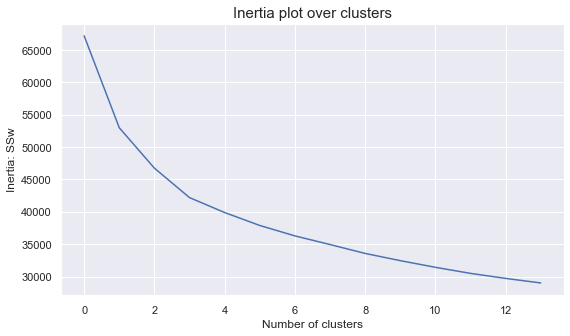

In [30]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.22169256242414487
For n_clusters = 3, the average silhouette_score is : 0.23707766584584286
For n_clusters = 4, the average silhouette_score is : 0.21036821905415626
For n_clusters = 5, the average silhouette_score is : 0.19514283937028068
For n_clusters = 6, the average silhouette_score is : 0.18736793579734382
For n_clusters = 7, the average silhouette_score is : 0.16983500681630878
For n_clusters = 8, the average silhouette_score is : 0.16670886503251847
For n_clusters = 9, the average silhouette_score is : 0.15495960560993288
For n_clusters = 10, the average silhouette_score is : 0.15066928575504182
For n_clusters = 11, the average silhouette_score is : 0.14808020070121977
For n_clusters = 12, the average silhouette_score is : 0.14847880590855292
For n_clusters = 13, the average silhouette_score is : 0.14905708672852927
For n_clusters = 14, the average silhouette_score is : 0.15283070598813156
For n_clusters = 15, the average 

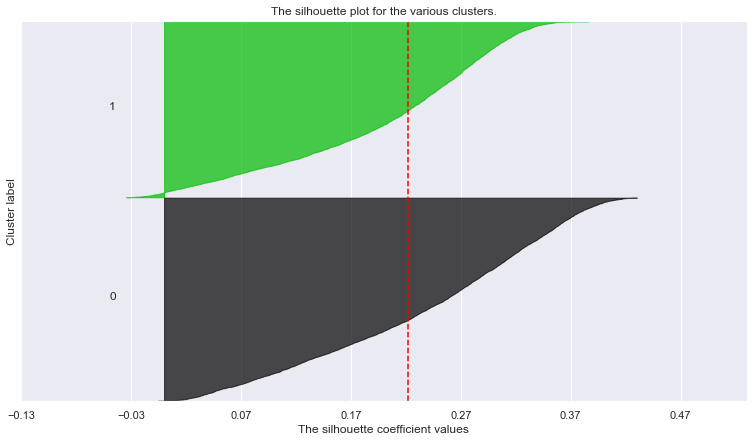

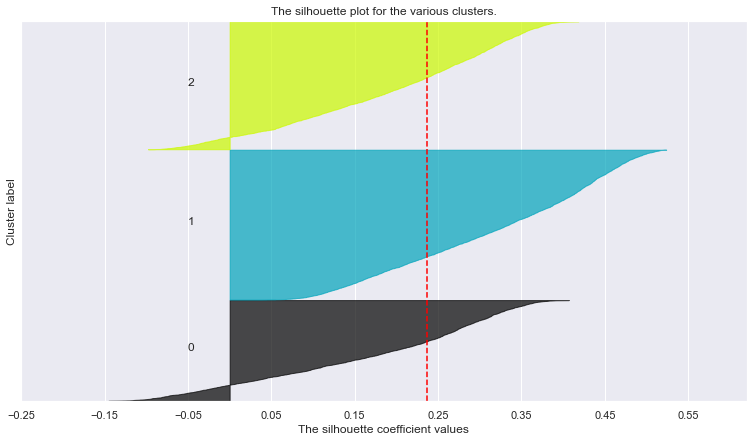

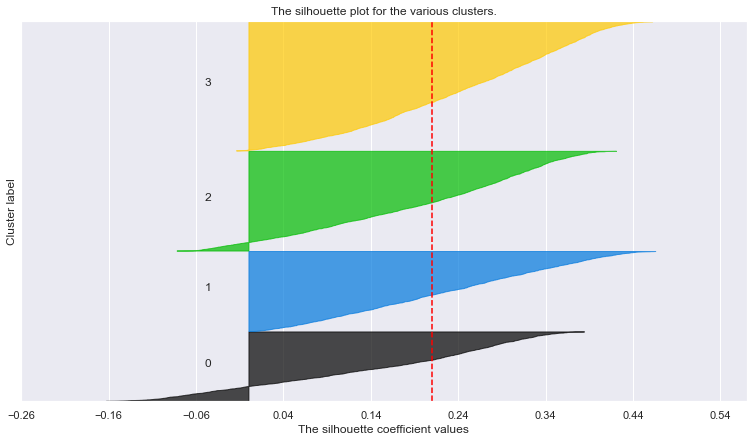

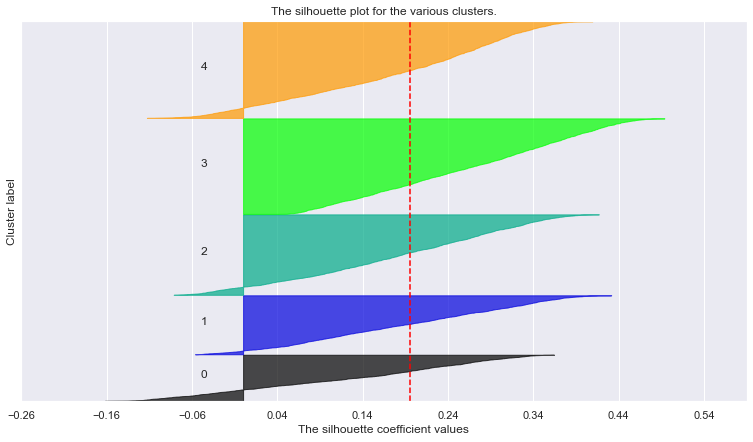

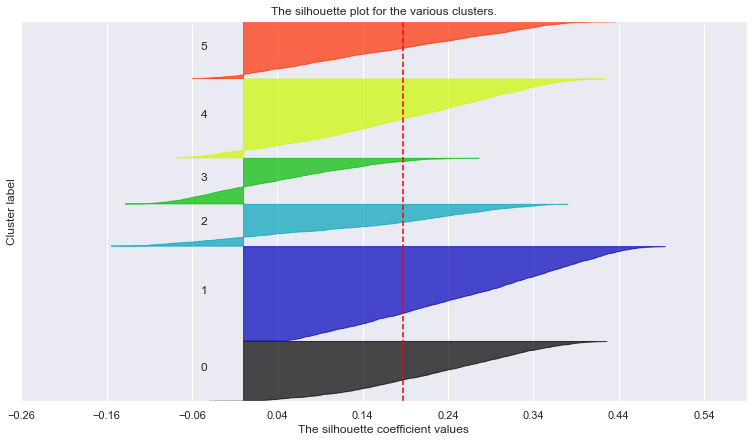

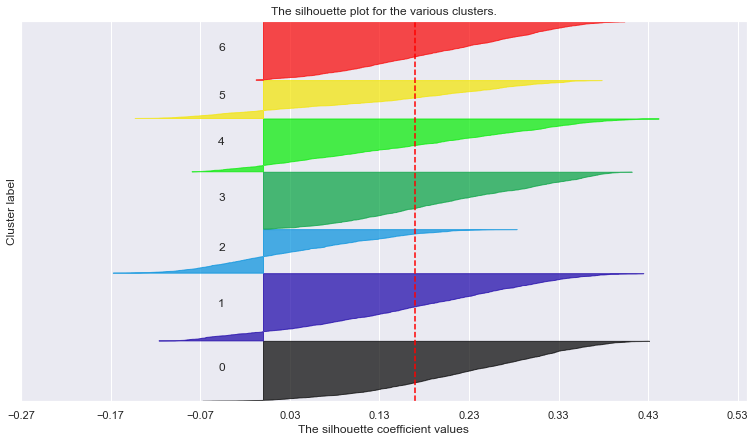

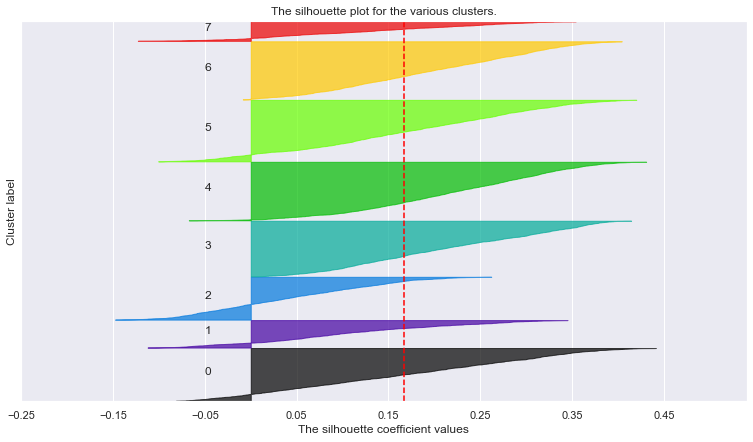

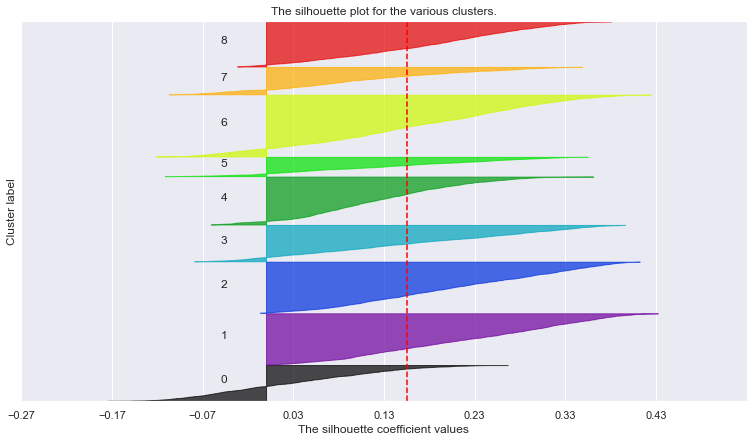

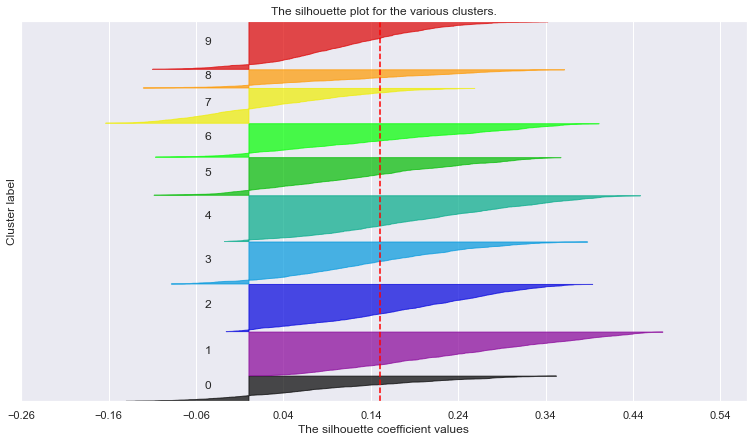

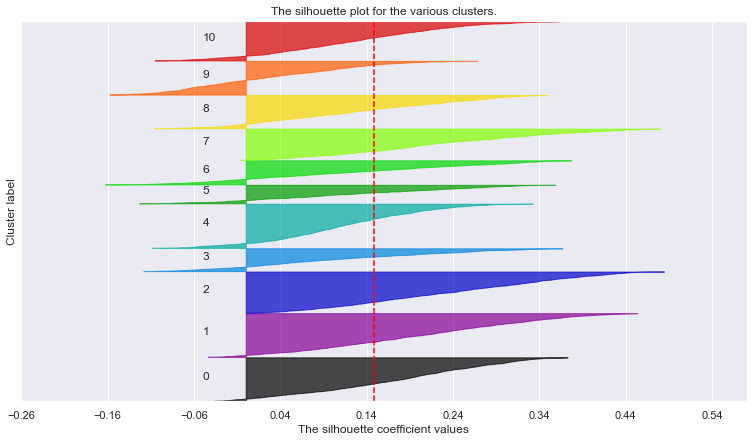

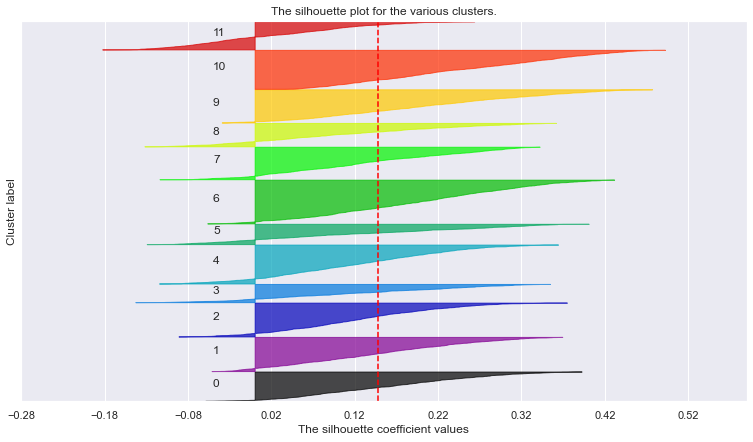

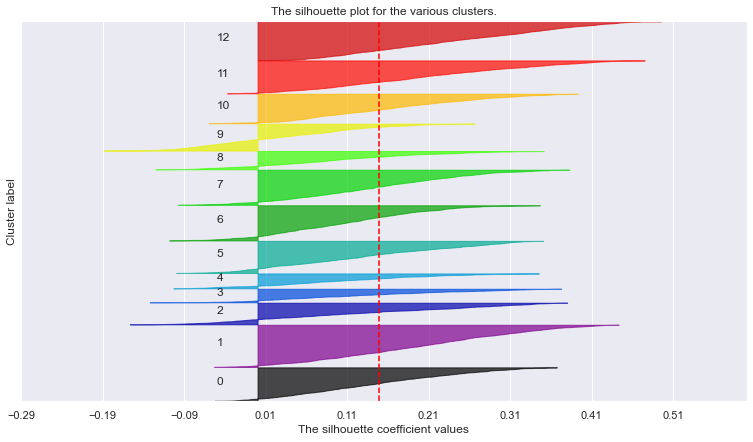

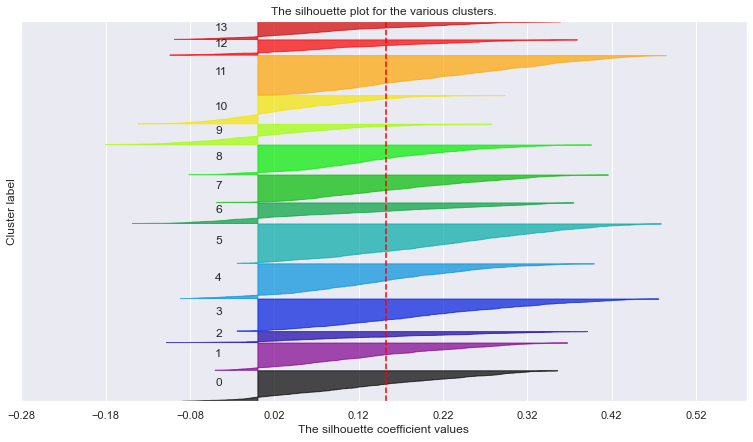

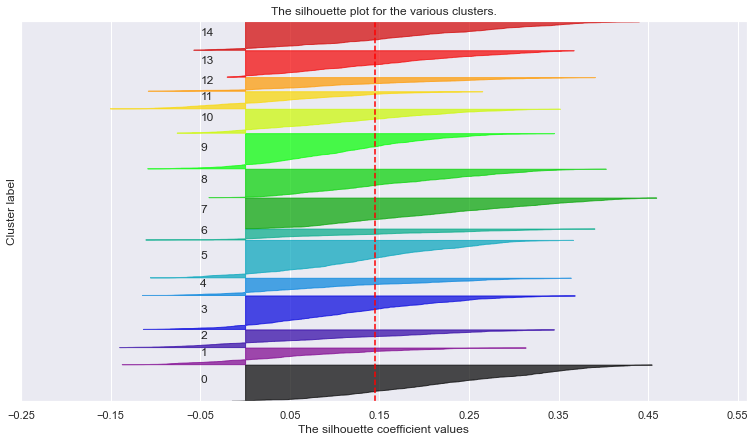

In [39]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg =  silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values =  silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

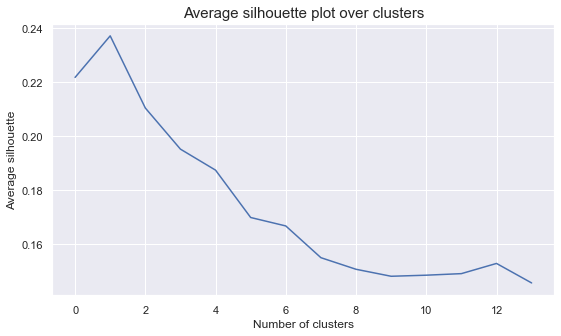

In [41]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [ ]:
# final cluster solution
number_clusters =  5
kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=5, random_state=1)
km_labels = # CODE HERE
km_labels

In [40]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

NameError: name 'km_labels' is not defined

### How can we combine the 2 algorithms?

## Exercise:
**Apply Hierarchical Clustering and K-means on the Principal Components.**

Choose the appropriate parameters and number of clusters for each algorithm and interpret each cluster based on the Principal Components interpretation: